# Глубинное обучение для текстовых данных, ФКН ВШЭ
## Домашнее задание 5: Retrieval‑Augmented Generation (RAG)
### Оценивание и штрафы

Максимально допустимая оценка за работу — __12 баллов__.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

__Мягкий дедлайн 04.12.25 23:59__ \
__Жесткий дедлайн 07.12.25 23:59__

### О задании

В этом домашнем задании вам предлагается реализовать ассистента для кулинарных советов с помощью RAG, который помимо всего прочего может ходить в итернет за дополнительной информацией. Всю логику системы нужно будет написать самостоятельно без специализорованных библиотек. Мы разделили ее на несколько логических компонент, каждой из которых будет отведено отдельное задание:
1. Векторная база данных с быстрым семантическим поиском
2. Разбиение текстов на куски.
3. Ранжирование документов по релевантности
4. Формирование контекста для модели и генерация ответа

### О данных

В качестве базы данных мы будем использовать пользовательские рецепты с сайта "Поваренок.Ру". Они получены с помощью веб-парсинга сайта, поэтому местами тексты недостаточно чистые. Всего в датасете содержится 84130 рецептов.

In [1]:
%load_ext autoreload
%autoreload 2

In [52]:
import matplotlib.pyplot as plt
import numpy as np

### Загрузка датасета и модели

Таблица с рецептами хранится в файле `povarenok.csv`. Каждая запись содержит название рецепта, список ингредиентов и сам рецепт. Несмотря на то, что всего датасете хранится 84130 записей, в рамках этого задания мы будем работать с первыми 10-ю тысячами для того, чтобы все работало быстрее. При желании вы можете взять больше.

In [53]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files=['povarenok.csv'], split='train')
dataset = dataset.select(range(10000))
dataset

Dataset({
    features: ['name', 'ingredients', 'text'],
    num_rows: 10000
})

In [4]:
dataset[0]

{'name': 'Густой молочно-клубничный коктейль',
 'ingredients': "['Молоко', 'Клубника', 'Сахар']",
 'text': 'Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!'}

Посмотрим на распределение длин текстов. Нам важно знать с чем мы имеем дело, ведь RAG подразумевает, что мы будем подавать тексты на вход модели.

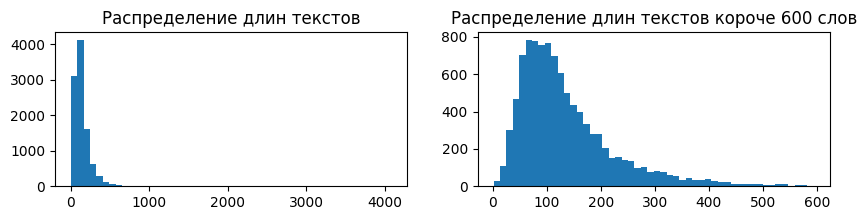

In [5]:
lens = np.array([len(dataset[i]['text'].split()) for i in range(len(dataset))])

plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.hist(lens, bins=50)
plt.title('Распределение длин текстов')

plt.subplot(1, 2, 2)
plt.hist(lens[lens < 600], bins=50)
plt.title('Распределение длин текстов короче 600 слов')

plt.show()

Видим, что тексты часто довольно длинные. Поэтому смухлевать не получится и перед векторизацией нужно будет разбивать каждый текст на небольшие куски, чтобы не перегружать контекст модели и чтобы потерять важную информацию при векторизацци текстов на этапе складывания их в векторную базу данных.

Приступим к реализации RAG.

## Retrieval‑Augmented Generation

В качестве основы для ассистента возьмите модель [`Qwen/Qwen2-1.5B-Instruct`](https://huggingface.co/Qwen/Qwen2-1.5B-Instruct) из huggingface. Важно, что это `Instruct` модель, то есть она предлазначена для общения в формате диалога.

__Задание 0 (0 баллов).__ Проверьте, как модель отвечает на кулинарные вопросы без RAG. Это необходимо сделать, чтобы понять, нужен ли вообще RAG для данной задачи.

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-1.5B-Instruct")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2-1.5B-Instruct")
messages = [
    {"role": "user", "content": "Who are you?"},
]
inputs = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=40)
print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

I am a large language model created by Alibaba Cloud. I am called Qwen.<|im_end|>


In [9]:
messages = [
    {"role": "user", "content": "Как приготовить клубничный молочный коктейль?"},
]
inputs = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=500)
print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

Клубничный молочный коктейль - это вкусная и легкая выпи, которую можно сделать дома. Вот рецепт:

Состав:
- 1/2 стакана клубники (мелко нарезанной)
- 30 мл молока
- 5 мл сахара

Инструкции:

1. Начните с смешивания молока и сахара в кофемашине или в микроволновке. Сделайте до образования однородного раствора.

2. Добавьте мелко нарезанные клубники в раствор молока и молока.

3. Перемешивайте все вместе до тех пор, пока не получится густая и плотная масса.

4. Подогрейте коктейль до тепла, но не доведите до кипения.

5. Украсьте ваш коктейль свежими клубникой или листьями мяты.

Приятного аппетита!<|im_end|>


In [10]:
messages = [
    {"role": "user", "content": "Рецепт куриных ребрышек?"},
]
inputs = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=500)
print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

Конечно, вот простой рецепт куриных ребрышек:

Ингредиенты:
- 2 куска куриных ребрышек
- 1 луковица
- 4 зубчика чеснока
- 3 картофелины
- 1 стакан сливок
- 1 стакан молока
- 1 столовая ложка соли
- 1/2 столовая ложка перец (пaprika)
- 1/2 столовая ложка корицы

Приготовление:
1. Натрите нарезанный лук и чеснок.
2. В сковороде обжарьте лук и чеснок до золотистого цвета.
3. Добавьте нарезанную картошку и обжарьте в течение 5 минут.
4. Смешайте все ингредиенты в кастрюлю.
5. Поставьте на средний огонь и доведите до кипения.
6. Залейте куриные ребрашки в кастрюлю и подержите на медленном огне около 10 минут, пока они не станут мягких.
7. Установите на небольшую гущу из кастрюли и добавьте сливки и молоко.
8. Пробудите суп до тех пор, пока оно не станет однородным.
9. Добавьте соль, перец и корицу по вкусу.
10. Оставьте его настаиваться еще 10 минут перед употреблением.

Надеюсь, это вам понравится! Если вы хотите изменить рецепт, вы можете добавить любые другие ингредиенты или сделать его 

In [11]:
messages = [
    {"role": "user", "content": "Рецепт легкого, полезного завтрака?"},
]
inputs = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=300)
print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

Давайте сначала рассмотрим основные компоненты для такого завтрака:

1. Овсяная каша: Это отличный источник клетчатки и витаминов A, D и E. Вы можете добавить орехи или семена на завтрак.

2. Фрукты: Включите в свой завтрак свежие фрукты, такие как яблоки, апельсины, бананы или груши. Они содержат много влаги и важных веществ, которые помогут вам начать день правильно.

3. Зелень: Включите зеленые листья, такие как капусту, морковь или редиску, в ваш завтрак. Они содержат множество витаминов и минералов.

4. Домашняя выпечка: Если вы любите сладкий вкус, вы можете приготовить домашнюю выпечку, например, хлеб или печенье. 

5. Берегите здоровье! Не забывайте о том, что в завтраке следует употреблять только продукты, которые вы обычно едите на обед и ужин. 

Вот ваш рецепт:
1. Составьте овсяную кашу из 1/2 стакана


### Locality Sensitive Hashing (LSH)

В RAG для каждого запроса необходимо искать релевантные документы по векторной базе данных. Так как документов очень много, подсчет релевантности для каждого из них будет занимать очень много времени. Поэтому нам важно, чтобы поиск был быстрым. Для достижения этого мы даже готовы немного пожертвовать точностью.

В этой секции вам предстоит реализовать [Locality Sensitive Hashing](https://ru.wikipedia.org/wiki/Locality-sensitive_hashing).

Идея LSH довольна проста. Разделим все векторы из базы данных на группы, состоящие из похожих векторов. В начале поиска определим группу, которая соответствует вектору запроса и будем считать релевантность только для объектов из этой группы. Для разбиения на группы мы введем несколько хеш-функций. Каждая их них будет строиться по следующему алгоритму:
1. Сгенерируем $k$ случайных векторов (векторы нормали гиперплоскости)
2. Для отдельной точки (вектора) в базе данных и вектора нормали запишем 1, если точка лежит над соответствующей гиперплоскостью. В обратном случае запишем 0.
3. Повторим процедуру для всех точек и векторов нормали. Так мы для каждой точки получим список из $k$ 0 и 1, который и будет хешем.
4. Запишем в хеш-таблицу найденные точки для каждого хеша.
5. Повторим шаги 1-4 $L$ раз и получим $L$ разных хеш-таблиц.

Теперь для каждого нового вектора $q$ мы можем очень быстро найти набор векторов похожих на него. Для этого посчитаем хеши запроса в каждой хеш-таблице и возьмем все точки, у которых хеш совпал c $q$ хотя бы в одной из них. Затем переранжируем найденные точки по релевантности (расстоянию до вектора запроса) и оставим заданное число самых близких.

Сложность формирования хеш-таблиц можно оценить как $O(nLkd)$, где $n$ – число векторов в базе данных, а $d$ – размерность вектора. В то же время сложность поиска LSH – $O(Lkd + (nLp) \cdot d)$, где $p$ – вероятность того, что хеш двух случайных точек совпадет ($p$ стремится к 0). Сложность полного перебора – $O(nd)$, поэтому при поиске LSH работает быстрее почти в $\frac{n}{Lk}$ раз!

__Задание 1 (3 балла).__ Реализуйте векторную базу данных LSH поиском. База данных должна уметь добавлять новые векторы, а так же по входному вектору быстро находить ближайшие к нему. Во время создании базы данных сгенерируйте необходимое число хеш-функций. Подумайте о том, как выбрать количество хеш-таблиц и число случайных векторов, а так же о том, из какого распределения брать эти случайные векторы. При добавлении нового вектора в базу данных, считайте для него хеш и записывайте, каким группам от принадлежит.

Постарайтесь оптимизировать код и не забудьте протестировать, что ваш LSH работает так, как надо. Проще всего это сделать, построив базу данных с точками на двумерной плоскости. Также сравните скорость LSH поиска с полным перебором. Если вы все сделали правильно, то для 1000 точек вы должны получить ускорение поиска примерно в 4 раза.

In [6]:
import torch
from time import time
from src.lsh import LSH, LS

data = [torch.randn(size=(2,)) for _ in range(1000)]
find = [torch.randn(size=(2,)) for _ in range(1000)]

lsh = LSH(2, 25, 2)
ls = LS()

for v in data:
    lsh.add(v)
    ls.add(v)

def compute_time(finder, data):
    total_time = 0
    for v in data:
        start_time = time()
        res = finder.find(v, n=3)
        total_time += time() - start_time
    return {'total_time': total_time, 'mean_time': total_time / len(data)}

In [20]:
compute_time(lsh, find)

{'total_time': 1.3054463863372803, 'mean_time': 0.0013054463863372803}

In [21]:
compute_time(ls, find)

{'total_time': 3.4626052379608154, 'mean_time': 0.0034626052379608152}

### Разбиение текста на куски

Так как некоторые тексты довольно длинные, если мы будем кодировать их целиком одним вектором, то часть информации потеряется. Вектор все таки имеет ограниченный размер. Чтобы не терять информацию, мы поделим текст на куски и будем кодировать каждый кусок отдельно.

__Задание 2 (2 балла).__ Реализуйте [рекурсивное разбиение](https://dev.to/eteimz/understanding-langchains-recursivecharactertextsplitter-2846) текста с уровнями `["\n\n", "\n", " ", ""]`. Добавьте пересечение между кусками для уровней `[" ", ""]`. То есть если целый абзац помещается в один кусок, то пересекать его ни с чем не надо (в нем содержится законченная мысль), а если абзац не влезает и его приходится делить по словам (или символам), то нужно добавить пересечение со словами из соседних кусков того же абзаца.

Значения для максимального размера каждого куска и длины пересечения выберите самостоятельно. Надежнее всего брать размер пересечения равным половине длины куска.

In [ ]:
# Проверим что все работает

from src.partition import TextPartition
import numpy as np
from tqdm import tqdm

for _ in tqdm(range(50)):
    max_len = np.random.randint(10, 1000)
    overlap_len = np.random.randint(1, max_len // 2)
    split_words = False
    if np.random.uniform(0, 1) > 0.5:
        split_words = True

    partition = TextPartition(max_len, overlap_len, split_words)
    for i in range(len(dataset)):
        parts = partition.split(dataset[i]['text'])

100%|██████████| 50/50 [00:19<00:00,  2.61it/s]


In [ ]:
# Пример разбиения

partition = TextPartition(100, 50, False)
parts = partition.split(dataset[1]['text'])

for part in parts:
    print(part)

Разобрать салат на отдельные листочки, помыть и просушить. Натереть на крупной терке сыр, яйца,
и просушить. Натереть на крупной терке сыр, яйца, выдавить через чесночницу чеснок. Лук порезать.
выдавить через чесночницу чеснок. Лук порезать. Несколько долек грейпфрута очистить от пленок,
Несколько долек грейпфрута очистить от пленок, нарезать на мелкие кусочки. Яйца отварить, почистить
на мелкие кусочки. Яйца отварить, почистить и мелко нарубить. Смешать все с майонезом. Выложить на
нарубить. Смешать все с майонезом. Выложить на листья салата и завернуть каждый в рулетик.


## RAG

Наконец мы можем начать собирать систему RAG. Для начала соберем векторую базу данных из кусков рецептов. Для получения эмбеддингов текстов возьмите модель [`intfloat/multilingual-e5-large`](https://huggingface.co/intfloat/multilingual-e5-large), она создана специально для этой задачи и хорошо работает с русским языком.

__Задание 3 (1 балл).__ Соберите векторую базу данных с помощью написанных вами функций. Процесс не должен занимать много времени с GPU, но мы рекомендуем сохранить результат на диск, чтобы не векторизовать весь датасет заново при перезапуске ядра. Проверьте, что по запросу возвращаются релевантные тексты.

In [42]:
from src.database import EmbededDataset, DataBase
from src.partition import TextPartition
from sentence_transformers import SentenceTransformer

#embeded_dataset = EmbededDataset(SentenceTransformer("intfloat/multilingual-e5-large", device="mps"), dataset, TextPartition(500))
#embeded_dataset.save()
embeded_dataset = EmbededDataset.load()

In [128]:
database = DataBase(embeded_dataset, L=5, k=10)

100%|██████████| 10000/10000 [00:13<00:00, 734.83it/s]


In [129]:
database.find("Клубничный молочный коктейль", 5)

[{'name': 'Густой молочно-клубничный коктейль',
  'ingredients': "['Молоко', 'Клубника', 'Сахар']",
  'text': 'Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!'},
 {'name': 'Клубнично-лаймовый коктейль',
  'ingredients': "['Клубника', 'Лайм', 'Сахар коричневый', 'Вода газированная']",
  'text': 'Для приготовления коктейля понадобится измельченная с сахаром клубника и доведенная до кипения. Я воспользовалась уже готовым сиропом, который приготовила моя мама. Лайм нарезаем ломтиками. На дно бокала наливаем клубничную смесь, добавляем немного сахара и кусочек лайма. Добавлеям газировку, пробуем, корректируем вкус, и можно подавать!'}]

### Формирование контекста для модели и генерация ответа

Из всех компонент RAG эта самая творческая. Надо придумать промпт, который будет лучше всего помогать модели генерировать ответ.

__Задание 4 (1 балл).__ Напишите функцию для генерации ответа по текстовому запросу в парадигме RAG. Найдите релевантные документы и соберите из них промпт, объяснив дополнительно модели, что от нее требуется. Количество текстов в промпте ограничивайте отбирая топ самых релевантных. Заметьте, что в нашем датасете помимо рецепта есть список ингредиентов и название блюда. Подумайте о том, как можно их использовать. Предайте промпт в модель для получения ответа. Подберите гиперпараметры генерации, чтобы контролировать разнообразие. Помните, что модель должна строго соответствовать инструкциям, не придумывать факты и не генерировать то, что от нее не требуется. Продемонстрируйте ваши результаты на 3-5 примерах.

In [ ]:
from src.model import RAGModel

model = RAGModel(database)

generation_params = {
    "max_new_tokens": 600,
    "temperature": 0.0,
    "do_sample": False,
}

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: c8694bea-10f8-4905-9e7c-3b98d2057a15)')' thrown while requesting HEAD https://huggingface.co/Qwen/Qwen2-1.5B-Instruct/resolve/main/config.json
Retrying in 1s [Retry 1/5].


Протестируем ответы и посмотрим какие рецепты модель имела на вход.

In [319]:
model.database.find("Рецепт клубничного молочного коктейля.", k=3)

[{'name': 'Густой молочно-клубничный коктейль',
  'ingredients': "['Молоко', 'Клубника', 'Сахар']",
  'text': 'Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!'},
 {'name': 'Клубнично-лаймовый коктейль',
  'ingredients': "['Клубника', 'Лайм', 'Сахар коричневый', 'Вода газированная']",
  'text': 'Для приготовления коктейля понадобится измельченная с сахаром клубника и доведенная до кипения. Я воспользовалась уже готовым сиропом, который приготовила моя мама. Лайм нарезаем ломтиками. На дно бокала наливаем клубничную смесь, добавляем немного сахара и кусочек лайма. Добавлеям газировку, пробуем, корректируем вкус, и можно подавать!'}]

In [316]:
print(model.generate("Рецепт клубничного молочного коктейля.", generation_params))

Название: Клубничный молочный коктейль
Ингредиенты: ['Клубника', 'Молоко', 'Сахар']
Инструкция по приготовлению:

1. Сначала поместите клубнику в блендер, затем добавьте молоко и сахар. 

2. Блендером взбивайте все вместе до тех пор, пока клубника не станет однородной массой.

3. После этого вылейте коктейль в стаканы и можете его употреблять, так как он будет очень холодным.

4. Если вам не нравится такой вкус, подождите и выпейте, когда коктейль немного прогреется.

5. Приятного аппетита!


In [320]:
model.database.find("Рецепт пастушьего пирога", k=3)

[{'name': 'Черёмуховый пирог "Простушка"',
  'ingredients': "['Мука пшеничная', 'Масло сливочное', 'Сахар', 'Черемуха', 'Вода', 'Яйцо куриное', 'Сметана', 'Крахмал картофельный']",
  'text': 'Заварить горячей водой черёмуху до консистенции сметаны на 40-60 мин. В муку добавить сливочное масло или маргарин кусочками, сахар и перетереть кончиками пальцев в крошку. В распаренную черёмуху добавить яйца, сахар, сметану и крахмал, тщательно перемешать. Дно разъёмной формы диам. 26-28 см выстелить пергаментной бумагой и смазать маргарином или слив. маслом. Высыпать 2/3 крошки на дно, аккуратно выложить начинку и обсыпать оставшейся крошкой. Выпекать в предварительно разогретой духовке при 180-200 гр. 45-50 мин., до того момента, когда серединка пирога перестанет колыхаться. Оставить в выключенной духовке ещё на 5 мин. Полностью остудить в форме, пройтись по бортикам ножом и выложить на блюдо. И с гордостью зовём своих близких отведать ароматный, вкусный пирожок! Приятного аппетита! А вот лако

In [317]:
print(model.generate("Рецепт пастушьего пирога", generation_params))

К сожалению, в базе данных нет рецепта пастушьего пирога.


In [321]:
model.database.find("Яйца по-ташкентски", k=3)

[{'name': 'Яичница по-ташкентски',
  'ingredients': "['Яйцо куриное', 'Помидор', 'Лук репчатый', 'Морковь', 'Масло растительное', 'Петрушка', 'Смесь перцев', 'Соль', 'Хмели-сунели']",
  'text': 'Морковь натереть на средней или крупной тёрке. Нарезать луковицу. В сковороду налить масло "Олейна", нагреть. Немного подержать на огне, помешивая. Перенести морковку к луку. Нарезать в это время помидоры. Когда морковь и лук потушатся, добавляем помидоры. Вбиваем в миску яйца. Всыпаем приправы и стебельки петрушки. Взбиваем и сразу заливаем омлетом овощи. Распределяем ложкой омлет по всей поверхности. Держим на небольшом огне, пока омлет не схватится. После выключения посыпать зеленью петрушки. Переносим на плоское большое блюдо. Делим на порции. Подаём в тёплом виде.'}]

In [318]:
print(model.generate("Яйца по-ташкентски", generation_params))

Название: Яйца по-ташкентски
Ингридиенты: ['Яйцо куриное', 'Помидор', 'Лук репчатый', 'Морковь', 'Масло растительное', 'Петрушка', 'Смесь перцев', 'Соль', 'Хмели-сунели']
Инструкция по приготовлению: 
1. Морковь натереть на средней или крупной тёрке. Нарезать луковицу. 
2. В сковороду налить масло "Олейна", нагреть. Немного подержать на огне, помешивая. Перенести морковку к луку. 
3. Нарезать в это время помидоры. 
4. Когда морковь и лук потушатся, добавляем помидоры. 
5. Вбиваем в миску яйца. 
6. Всыпаем приправы и стебельки петрушки. 
7. Взбиваем и сразу заливаем омлетом овощи. 
8. Распределяем ложкой омлет по всей поверхности. 
9. Держим на небольшом огне, пока омлет не схватится. 
10. После выключения посыпаем зеленью петрушки. 
11. Переносим на плоское большое блюдо. 
12. Делим на порции. 
13. Подаём в тёплом виде.

К сожалению, в моей базе данных нет рецептов по вашему запросу.


### Поиск в интернете

Как вы должны были заметить, языковая модель с RAG работает куда лучше, чем без него. Несмотря на это, она все равно регулярно галлюционирует. Качество RAG подхода помимо самих компонент RAG во многом зависит от датасета и модели. Например, датасет с рецептами может не содержать каких-то фактов о самих блюдах, а некоторых блюд вообще может не быть. В таком случае модель не сможет правильно ответить на вопрос. Давайте улучшим качество формирования контекста, добавив возможность сестеме искать информацию в интернете.

__Задание 5 (2 балла).__ Модифицируйте процесс извлечения релевантных текстов следующим образом. Если в топе оказались тексты с недостаточно высокой (по порогу) похожестью на запрос, то замените их текстами, найденными по запросу в интернете, у которых похожесть достаточно высокая. Таким образом, модель всегда будет получать фиксированное число максимально релевантных текстов на вход.

При поиске в интернете мы будем пользоваться тем, что все поисковики сортируют выдачу по соответствию запросу. Значит мы можем взять наш запрос, вставить его в поисковик и пройти по выданным ссылкам, анализируя текст на каждой странице до тех пор, пока не наберем достаточное число релевантных текстов. Для хождения в интернет вам потребуется библиотека [`requests`](https://requests.readthedocs.io/en/latest/), а для извлечения текста со страницы проще всего использовать [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

Получилось ли у вас улучшить качество ответов?

In [ ]:
# your code here

__Бонус [история] (1 балл)__. Важный недостаток текущего подхода заключается в том, что ассистенту нельзя задавать уточняющие вопросы по его же ответам. Приходится переписывать весь запрос целиком, добавляя больше деталей. Это, в целом, решение, но будет лучше, если в системе будет сохраняться история общения, а затем использоваться при генерации нового ответа. В этом задании вам предлагается добавить этот функционал. 

Существует много способов встраивания истории в модель. Например, можно просто сохранить все вопросы и ответы и подавать их в контекст. Однако такой способ значительно увеличит размер промпта, из-за чего увеличатся затраты по времени и памяти на каждый ответ. Конечно, можно попробовать фильтровывать историю, оставляя только те запросы и ответы, которые касаются текущего запроса. Тем не менее, это все еще будет перегружать промпт. Поэтому есть подход куда лучше.   
Перед поиском релевантных текстов попросим модель переформулировать полученный запрос так, чтобы он стал более полным и включал в себя контекст предыдущего общения. Например, `"Какая у него каллорийность?" -> "Какая каллорийность у салата Цезарь?"`. С таким новым запросом мы сможем искать релевантные тексты с учетом истории, не увеличивая итоговый размер промпта.

Реализуйте описанную схему. Для переформулирования запроса используйте ту же модель, что и для генерации, и убедитесь, что она хорошо справляется со своей задачей. С какими сложностями вы столкнулись?

In [ ]:
# your code here

__Задание 6 (1 балл).__ Продемонстрируйте работу вашего финального ассистента в различных сценариях (разные темы вопросов, разная сложность). Приведите примеры как удачных, так и неудачных ответов. Почему ваша система не всегда работает как надо? Какие у нее есть ограничения и какие преимущества? Как вы думаете, что можно сделать, чтобы ее улучшить?

In [ ]:
# your code here

__Бонус [Self-Query] (1 балл)__. Предлагаем вам почитать про метод [SelfQuery](https://medium.com/%40danushidk507/rag-x-self-query-retriever-952dd55c68ed) и реализовать его. Если описывать вкратце: мы при помощи модели проводим предобработку запроса и выделяем из него некоторые метаданные, по которым можем фильтроваться по датасету. Например, в запросе "хочу что-то сладкое клубничное, но без манго" выделим продукты "клубника" и "манго", а дальше проведём фильтр по базе данных на основе продуктов, и в полученном подмножестве найдём "что-то сладкое".

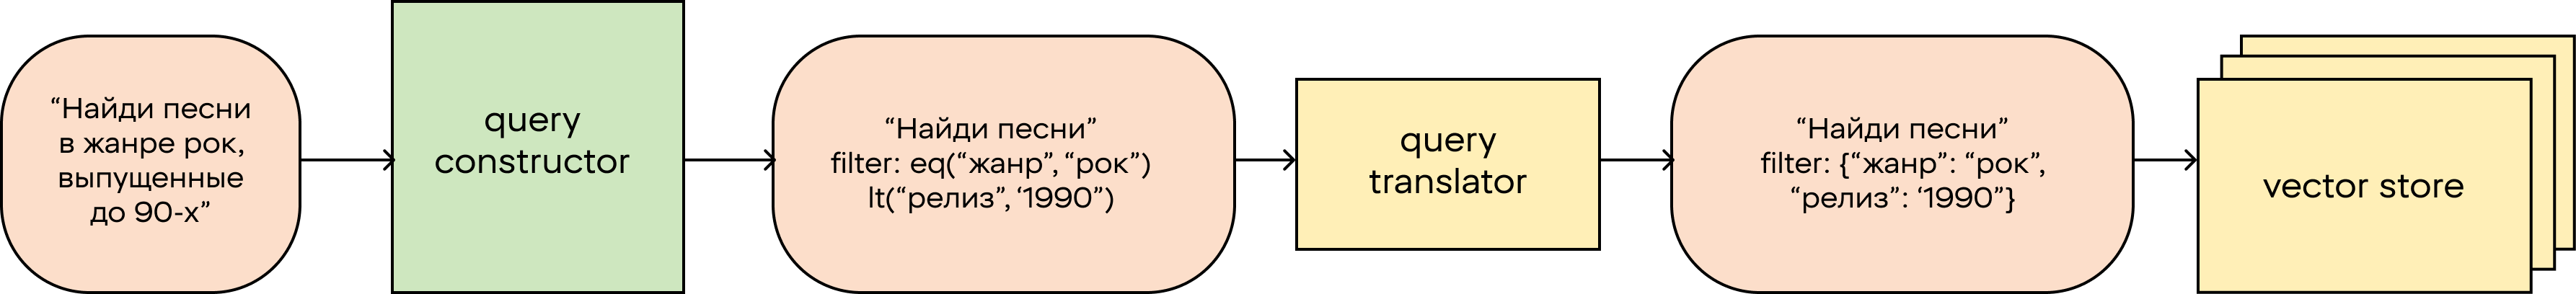

Для выделения метаданных можете воспользоваться либо генерацией json'а в определенном формате, либо SGR.

[Schema-Guided Reasoning (SGR)](https://abdullin.com/schema-guided-reasoning/) — это метод, который побуждает большие языковые модели (LLM) к созданию структурированных, понятных и предсказуемых ответов, заставляя их рассуждать по заранее определённым шагам. Создавая специальную схему (или структурированный шаблон), вы явно задаёте:

* какие этапы модель обязана пройти (не допускает пропуска или потери логики),
* в каком порядке должна происходить цепочка рассуждений (обеспечивает связность),
* на что именно следует обратить внимание (повышает глубину и точность).

Вместо свободной генерации текста — часто непоследовательной или двусмысленной — схема выступает жёстким ориентиром. Эта структура затем принудительно применяется к модели с помощью ограниченного декодирования (structured output).